# Statistical Dependency Analysis

This notebook implements:
- Chi-square dependency analysis
- Proxy NPV estimation using Linear Regression
- Model evaluation on training and control datasets


In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import chi2_contingency
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns


## Data Loading

The dataset consists of two parts:
- Training dataset — used for analysis and model building
- Control dataset — used for final model evaluation


In [3]:
file_path = "../data/raw/Task_1.xlsx"

df_test = pd.read_excel(file_path, header=0, sheet_name='Control dataset', engine='openpyxl')
df_train = pd.read_excel(file_path, header=0, sheet_name='Training dataset', engine='openpyxl')


## Initial Data Inspection

We perform a basic inspection to understand feature structure and data quality.


In [7]:
df_train.head()

,Unnamed: 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,NPV
0,1,P10,P10P50,X,P90,X,P50P90,P90P50,P90P50,P10P50,P50P10,1871.515361
1,2,P10,P50P50,P50,P90,P50P10,P10P10,P90P50,P10P90,P10P50,P90P50,5345.484763
2,3,P50,P10P90,P10,P50,P90P50,P10P50,P50P90,P10P50,P10P90,P50P90,2754.839189
3,4,P90,P90P50,P10,P10,P90P50,P10P10,P10P90,P10P10,P90P10,P90P50,2111.623643
4,5,P50,P50P10,P90,P10,P90P50,P90P10,P10P50,P10P90,P10P10,P10P10,3824.497677


## Data Preprocessing and Encoding

Categorical project features are encoded numerically to enable statistical analysis
and regression modeling.

Missing or placeholder values are handled explicitly.


In [ ]:
df_test.replace('X', 0, inplace=True)
df_train.replace('X', 0, inplace=True)


data_encoding = {'P90P90': 1, 'P90P50': 2, 'P50P90': 3,
        'P90P10': 4, 'P50P50': 5, 'P10P90': 6, 'P90': 7,
        'P50P10': 8, 'P10P50': 9, 'P50': 10, 'P10P10': 11, 'P10': 12}

df_test.replace(data_encoding, inplace=True)
df_train.replace(data_encoding, inplace=True)

## Statistical Dependency Analysis

We test statistical hypotheses of independence between each pair of categorical features
using the Chi-square test.

Significance level: α = 0.05


In [9]:
selected_columns = df_train.columns[1:11]
alpha = 0.05
chi2_results = []

for col1, col2 in combinations(selected_columns, 2):
    conjugacy_table = pd.crosstab(df_train[col1], df_train[col2])
    chi2, p, dof, expected = chi2_contingency(conjugacy_table)

    chi2_results.append({
        'Feature 1': col1,
        'Feature 2': col2,
        'chi2': chi2,
        'p_value': p,
        'Dependency': 'Yes' if p < alpha else 'No'
    })

chi2_df = pd.DataFrame(chi2_results)
chi2_df

,Feature 1,Feature 2,chi2,p_value,Dependency
0,Feature 1,Feature 2,21.818674,5.900886e-01,No
1,Feature 1,Feature 3,10.618668,3.027551e-01,No
2,Feature 1,Feature 4,4.688528,5.843360e-01,No
3,Feature 1,Feature 5,18.523451,7.769033e-01,No
4,Feature 1,Feature 6,28.469277,2.407452e-01,No
5,Feature 1,Feature 7,26.411361,1.911961e-01,No
6,Feature 1,Feature 8,30.500996,1.686974e-01,No
7,Feature 1,Feature 9,9.921370,9.799148e-01,No
8,Feature 1,Feature 10,15.580780,9.026102e-01,No
9,Feature 2,Feature 3,22.229066,5.655968e-01,No


## Proxy NPV Model

A Linear Regression model is implemented manually using the normal equation
to ensure full transparency and interpretability of the estimation process.


In [11]:
class my_LinearRegression:
    
    def fit(self, X, y):
        X = np.array(X)
        X = np.c_[np.ones(X.shape[0]), X]
        y = np.array(y)
        self.coef = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    def predict(self, X):
        X = np.array(X)
        X = np.c_[np.ones(X.shape[0]), X]
        return X.dot(self.coef)

## Model Training and Evaluation


In [12]:
X_train = df_train[selected_columns]
y_train = df_train['NPV']

X_test = df_test[selected_columns]
y_test = df_test['NPV']

model = my_LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

r2_train, r2_test

(0.8420855473646629, 0.847338209046218)

## Visualization of Results


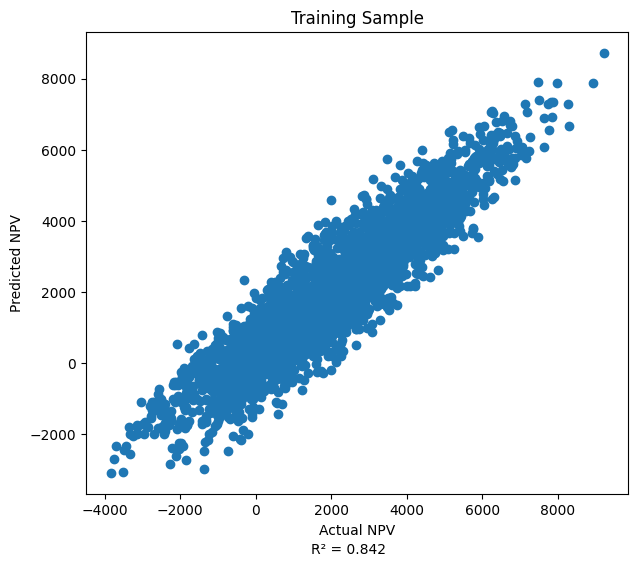

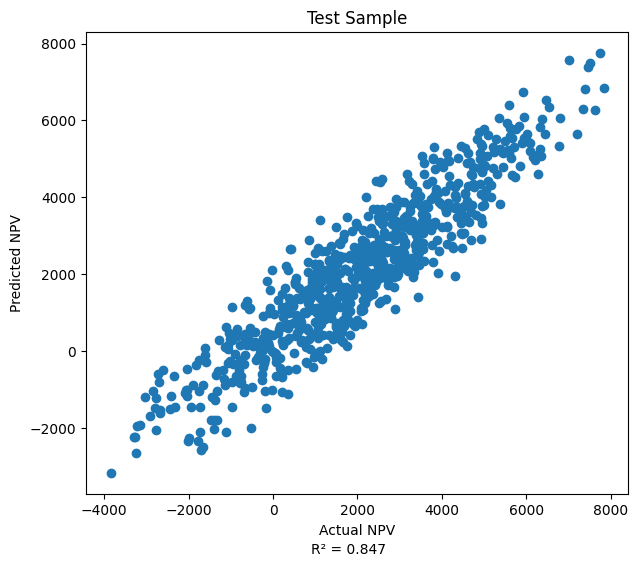

In [13]:
plt.figure(figsize=(7, 6))
plt.scatter(y_train, y_pred_train)
plt.xlabel("Actual NPV")
plt.ylabel("Predicted NPV")
plt.title(f"Training Sample")
plt.figtext(0.5, 0.01, f"R² = {r2_train:.3f}", ha="center")
plt.show()


plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred_test)
plt.xlabel("Actual NPV")
plt.ylabel("Predicted NPV")
plt.title("Test Sample")
plt.figtext(0.5, 0.01, f"R² = {r2_test:.3f}", ha="center")
plt.show()

## Linear Correlation Matrix


C:\Users\pc\AppData\Local\Temp\ipykernel_17052\3451407506.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = highlight.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else "")


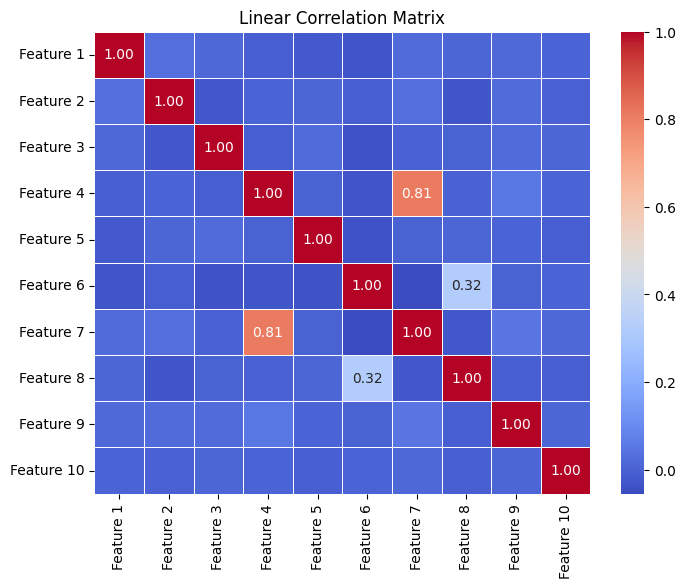

In [16]:
signs = df_train[selected_columns]
matrix_correlation = signs.corr()


highlight = matrix_correlation.copy()
highlight[np.abs(highlight) < 0.2] = np.nan
annot = highlight.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else "")

plt.figure(figsize=(8, 6))
sns.heatmap(matrix_correlation, annot=annot, cmap='coolwarm', fmt="", linewidths=0.5)
plt.title("Linear Correlation Matrix")
plt.show()

## Full Linear Correlation Matrix


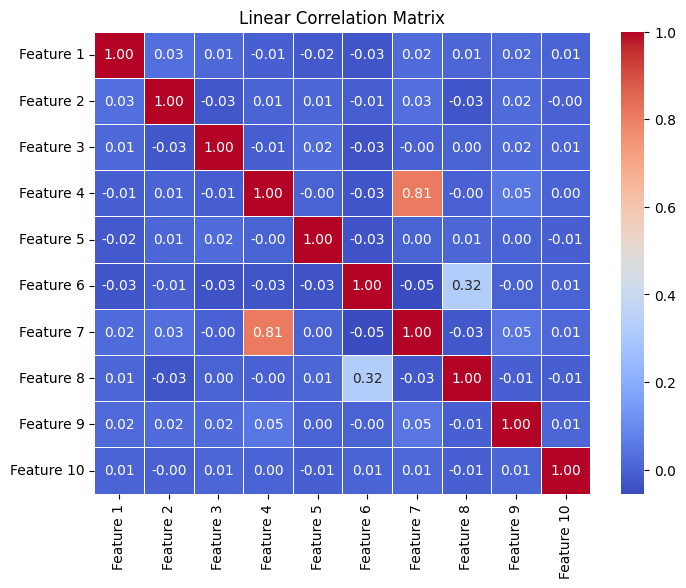

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Linear Correlation Matrix")
plt.show()

## Conclusions

- Statistically significant dependencies between several project features were identified
- Linear Regression provides a reasonable proxy for NPV estimation
- Model performance differs between training and control datasets, indicating generalization quality
- The tool can be used for primary screening and exploratory analysis of investment projects
